Nesta etapa, vamos transformar o dataset limpo (`dados_limpos.csv`) em um formato tidy data, seguindo os princípios:
- Cada variável é uma coluna.
- Cada observação é uma linha.
- Cada tipo de unidade observacional forma uma tabela.

Ao final, exportaremos o resultado em formato Parquet, mais eficiente e padronizado.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

In [2]:
df = pd.read_csv("dados_limpos.csv")
print("Dimensões iniciais:", df.shape)

Dimensões iniciais: (2238106, 42)


## 1) Preparação dos Dados em Formato Tidy

Padronização dos tipos de dados: converte colunas categóricas em category, numéricas inteiras em Int64 e valores decimais em float com duas casas decimais.

In [3]:
cols_categoricas = ["TP_SEXO", "SG_UF_PROVA", "Q001", "Q002", "Q006"]
for col in cols_categoricas:
    df[col] = df[col].astype("category")

cols_inteiras = [
    "NU_ANO", "TP_FAIXA_ETARIA", "TP_ESTADO_CIVIL", "TP_COR_RACA",
    "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ESCOLA", "IN_TREINEIRO",
    "CO_UF_PROVA", "TP_PRESENCA_CN", "TP_PRESENCA_CH", "TP_PRESENCA_LC",
    "TP_PRESENCA_MT", "TP_LINGUA", "TP_STATUS_REDACAO",
    "NU_NOTA_COMP1", "NU_NOTA_COMP2", "NU_NOTA_COMP3",
    "NU_NOTA_COMP4", "NU_NOTA_COMP5", "NU_NOTA_REDACAO",
    "Q022", "Q024", "Q025", "ANO_REFERENCIA"
]
df[cols_inteiras] = df[cols_inteiras].astype("Int64")

cols_float = [
    "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT",
    "PCT_ACERTO_CN", "PCT_ACERTO_CH", "PCT_ACERTO_LC", "PCT_ACERTO_MT"
]
df[cols_float] = df[cols_float].astype(float).round(2)

Normalização das variáveis TX_ACERTOS_*, que são sequências de 0 e 1 indicando acertos e erros.
Aqui são criadas colunas numéricas com o total de acertos e o total de questões por área (CN, CH, LC e MT).

In [4]:
for area in ["CN", "CH", "LC", "MT"]:
    col = f"TX_ACERTOS_{area}"
    if col in df.columns:
        df[f"ACERTOS_{area}"] = df[col].astype(str).apply(lambda x: x.count("1") if pd.notna(x) else None)
        df[f"TOTAL_{area}"] = df[col].astype(str).apply(lambda x: len(x) if pd.notna(x) else None)

Transformação do dataset de formato wide para long, reorganizando as notas (NU_NOTA_*) para que cada linha represente um aluno em uma área específica (AREA_CONHECIMENTO).

In [5]:
id_vars = [
    "NU_ANO", "TP_FAIXA_ETARIA", "TP_SEXO", "TP_ESTADO_CIVIL",
    "TP_COR_RACA", "TP_NACIONALIDADE", "TP_ST_CONCLUSAO", "TP_ESCOLA",
    "IN_TREINEIRO", "CO_UF_PROVA", "SG_UF_PROVA", "TP_LINGUA",
    "TP_STATUS_REDACAO", "NU_NOTA_REDACAO", "ANO_REFERENCIA", "Q001", 
    "Q002", "Q006", "Q022", "Q024", "Q025"
]

df_long_notas = df.melt(
    id_vars=id_vars,
    value_vars=["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT"],
    var_name="AREA_CONHECIMENTO",
    value_name="NOTA"
)
df_long_notas["AREA_CONHECIMENTO"] = df_long_notas["AREA_CONHECIMENTO"].str.replace("NU_NOTA_", "")

Aplicação da mesma transformação (melt) para as variáveis de percentual de acerto (PCT_ACERTO_*), número de acertos (ACERTOS_*) e total de questões (TOTAL_*).

In [6]:
df_long_pct = df.melt(
    id_vars=id_vars,
    value_vars=["PCT_ACERTO_CN", "PCT_ACERTO_CH", "PCT_ACERTO_LC", "PCT_ACERTO_MT"],
    var_name="AREA_CONHECIMENTO",
    value_name="PCT_ACERTO"
)
df_long_pct["AREA_CONHECIMENTO"] = df_long_pct["AREA_CONHECIMENTO"].str.replace("PCT_ACERTO_", "")

df_long_acertos = df.melt(
    id_vars=id_vars,
    value_vars=["ACERTOS_CN", "ACERTOS_CH", "ACERTOS_LC", "ACERTOS_MT"],
    var_name="AREA_CONHECIMENTO",
    value_name="ACERTOS"
)
df_long_acertos["AREA_CONHECIMENTO"] = df_long_acertos["AREA_CONHECIMENTO"].str.replace("ACERTOS_", "")

df_long_total = df.melt(
    id_vars=id_vars,
    value_vars=["TOTAL_CN", "TOTAL_CH", "TOTAL_LC", "TOTAL_MT"],
    var_name="AREA_CONHECIMENTO",
    value_name="TOTAL_QUESTOES"
)
df_long_total["AREA_CONHECIMENTO"] = df_long_total["AREA_CONHECIMENTO"].str.replace("TOTAL_", "")

Combinação das tabelas geradas na etapa anterior, unindo notas, acertos e percentuais em um único dataset tidy (df_tidy).

In [7]:
df_tidy = df_long_notas.copy()
df_tidy["PCT_ACERTO"] = df_long_pct["PCT_ACERTO"]
df_tidy["ACERTOS"] = df_long_acertos["ACERTOS"]
df_tidy["TOTAL_QUESTOES"] = df_long_total["TOTAL_QUESTOES"]

print("Dimensões finais (tidy):", df_tidy.shape)
df_tidy.head()

Dimensões finais (tidy): (8952424, 26)


,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,IN_TREINEIRO,CO_UF_PROVA,...,Q002,Q006,Q022,Q024,Q025,AREA_CONHECIMENTO,NOTA,PCT_ACERTO,ACERTOS,TOTAL_QUESTOES
0,2021,12,M,1,1,1,1,1,0,27,...,B,B,1,0,0,CN,505.9,31.11,14,45
1,2021,3,M,1,3,1,2,2,0,23,...,B,B,1,1,1,CN,580.7,37.78,17,45
2,2021,2,F,1,3,1,2,2,0,23,...,E,C,1,1,1,CN,497.7,26.67,12,45
3,2021,8,F,1,3,1,2,2,0,31,...,B,B,1,0,1,CN,487.4,26.67,12,45
4,2021,4,F,1,3,1,2,2,0,29,...,D,B,1,0,1,CN,507.6,28.89,13,45


Exportação do dataset final em formato Parquet, garantindo compactação, preservação dos tipos de dados e maior eficiência de leitura.


In [8]:
df_tidy.to_parquet("dados_tidy.parquet", index=False)
print("Dados tidy exportados com sucesso para 'dados_tidy.parquet'")

Dados tidy exportados com sucesso para 'dados_tidy.parquet'


In [9]:
area_labels = {
    "CN": "Ciências da Natureza",
    "CH": "Ciências Humanas",
    "LC": "Linguagens e Códigos",
    "MT": "Matemática"
}

df_tidy["AREA_LABEL"] = df_tidy["AREA_CONHECIMENTO"].map(area_labels)

## 2) Consultas

Análise de tendências temporais: evolução das notas médias por área ao longo dos anos.

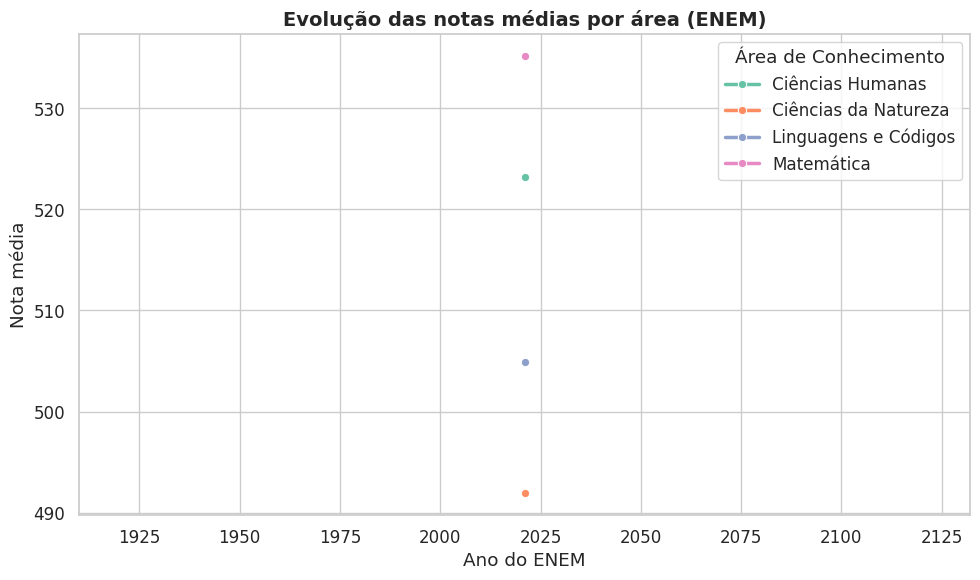

In [10]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

media_ano_area = (
    df_tidy.groupby(["NU_ANO", "AREA_LABEL"])["NOTA"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=media_ano_area,
    x="NU_ANO",
    y="NOTA",
    hue="AREA_LABEL",
    marker="o",
    linewidth=2.5
)

plt.title("Evolução das notas médias por área (ENEM)", fontsize=14, weight="bold")
plt.xlabel("Ano do ENEM")
plt.ylabel("Nota média")
plt.legend(title="Área de Conhecimento", loc="best", frameon=True)
plt.tight_layout()
plt.show()

Comparação entre grupos: médias de nota por sexo e área de conhecimento.

/tmp/ipykernel_8628/1311880190.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_tidy.assign(SEXO=df_tidy["TP_SEXO"].replace(sexo_labels))
/tmp/ipykernel_8628/1311880190.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["SEXO", "AREA_LABEL"])["NOTA"]


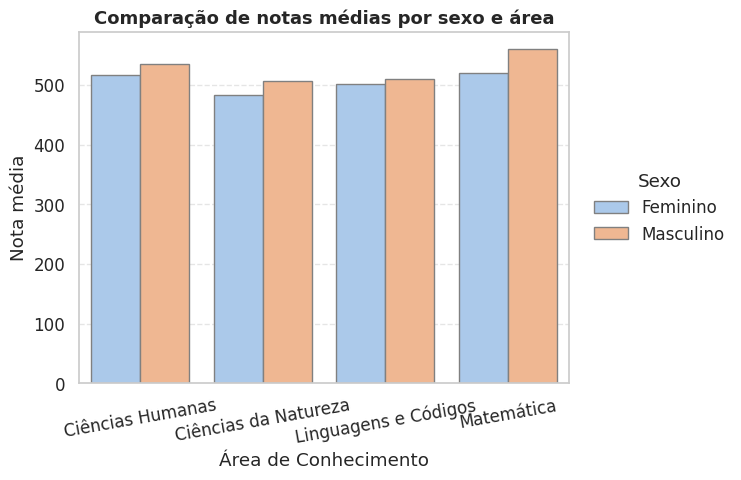

In [11]:
sexo_labels = {"F": "Feminino", "M": "Masculino"}
media_sexo_area = (
    df_tidy.assign(SEXO=df_tidy["TP_SEXO"].replace(sexo_labels))
    .groupby(["SEXO", "AREA_LABEL"])["NOTA"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=media_sexo_area,
    x="AREA_LABEL",
    y="NOTA",
    hue="SEXO",
    palette="pastel",
    edgecolor="gray"
)

plt.title("Comparação de notas médias por sexo e área", fontsize=13, weight="bold")
plt.xlabel("Área de Conhecimento")
plt.ylabel("Nota média")

plt.legend(
    title="Sexo",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    frameon=False
)

plt.xticks(rotation=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

Análise de concentração: distribuição das notas por área.

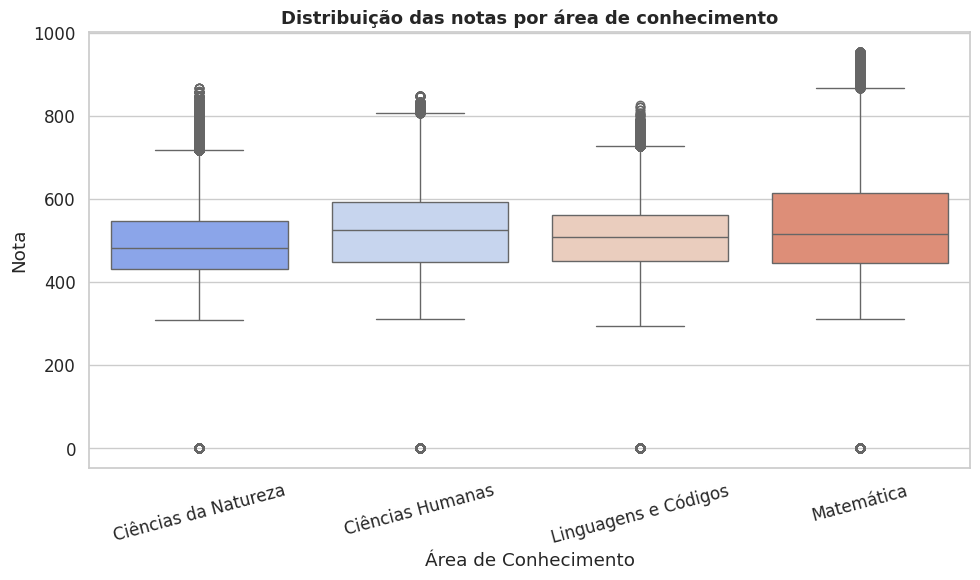

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_tidy,
    x="AREA_LABEL",
    y="NOTA",
    hue="AREA_LABEL",
    legend=False,
    palette="coolwarm"
)

plt.title("Distribuição das notas por área de conhecimento", fontsize=13, weight="bold")
plt.xlabel("Área de Conhecimento")
plt.ylabel("Nota")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Ranking de desempenho médio por estado (SG_UF_PROVA).

In [13]:
ranking_estados = (
    df_tidy.groupby("SG_UF_PROVA")["NOTA"]
    .mean()
    .reset_index()
    .sort_values(by="NOTA", ascending=False)
)

ranking_estados["RANK"] = ranking_estados["NOTA"].rank(ascending=False)
ranking_estados.head(27)

/tmp/ipykernel_8628/1793840095.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tidy.groupby("SG_UF_PROVA")["NOTA"]


,SG_UF_PROVA,NOTA,RANK
25,SP,540.020195,1.0
10,MG,533.659448,2.0
6,DF,532.406726,3.0
23,SC,531.409579,4.0
22,RS,528.479523,5.0
18,RJ,527.629520,6.0
17,PR,526.527249,7.0
7,ES,524.942773,8.0
19,RN,510.041879,9.0
11,MS,508.383398,10.0


Detecção de padrões e anomalias.

In [14]:
media_area = df_tidy.groupby("AREA_CONHECIMENTO")["NOTA"].mean()
std_area = df_tidy.groupby("AREA_CONHECIMENTO")["NOTA"].std()

df_tidy["Z_SCORE"] = df_tidy.apply(
    lambda x: (x["NOTA"] - media_area[x["AREA_CONHECIMENTO"]]) / std_area[x["AREA_CONHECIMENTO"]],
    axis=1
)

anomalias = df_tidy[df_tidy["Z_SCORE"].abs() > 2]
print(f"Total de possíveis anomalias: {len(anomalias)}")
anomalias.head()

Total de possíveis anomalias: 284646


,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,IN_TREINEIRO,CO_UF_PROVA,...,Q022,Q024,Q025,AREA_CONHECIMENTO,NOTA,PCT_ACERTO,ACERTOS,TOTAL_QUESTOES,AREA_LABEL,Z_SCORE
42,2021,4,M,1,1,1,1,1,0,33,...,1,1,1,CN,664.9,62.22,28,45,Ciências da Natureza,2.149063
48,2021,3,F,1,1,1,2,2,0,35,...,1,1,1,CN,679.2,62.22,28,45,Ciências da Natureza,2.326703
59,2021,4,F,1,3,1,1,1,0,31,...,1,1,1,CN,710.3,77.78,35,45,Ciências da Natureza,2.713039
77,2021,6,M,1,3,1,1,1,0,31,...,1,0,1,CN,699.1,73.33,33,45,Ciências da Natureza,2.573909
102,2021,8,M,1,1,1,1,1,0,31,...,1,0,1,CN,658.4,60.00,27,45,Ciências da Natureza,2.068317


Correlações e dependências entre variáveis.

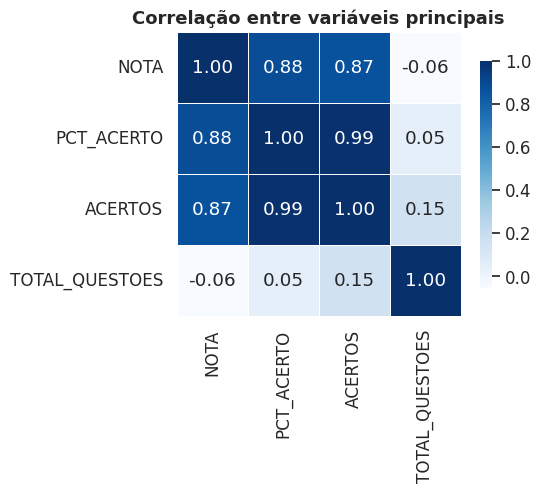

In [15]:
corr_df = df_tidy[["NOTA", "PCT_ACERTO", "ACERTOS", "TOTAL_QUESTOES"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)
plt.title("Correlação entre variáveis principais", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


Análise hierárquica com CTEs (simuladas via pandas).

In [16]:
media_estado = df_tidy.groupby("SG_UF_PROVA")["NOTA"].mean().reset_index(name="MEDIA_ESTADO")
media_nacional = media_estado["MEDIA_ESTADO"].mean()

media_estado["DIF_MEDIA_NACIONAL"] = media_estado["MEDIA_ESTADO"] - media_nacional
media_estado.sort_values("MEDIA_ESTADO", ascending=False).head(10)

/tmp/ipykernel_8628/1361494091.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_estado = df_tidy.groupby("SG_UF_PROVA")["NOTA"].mean().reset_index(name="MEDIA_ESTADO")


,SG_UF_PROVA,MEDIA_ESTADO,DIF_MEDIA_NACIONAL
25,SP,540.020195,34.348147
10,MG,533.659448,27.987400
6,DF,532.406726,26.734679
23,SC,531.409579,25.737531
22,RS,528.479523,22.807475
18,RJ,527.629520,21.957472
17,PR,526.527249,20.855201
7,ES,524.942773,19.270725
19,RN,510.041879,4.369831
11,MS,508.383398,2.711350
